In [1]:
import sys
import os
sys.path.append('/home/franzi/anzeigendaten/python_base/skillextraktion/fh_ma')
sys.path.append('/home/franzi/anzeigendaten/EnvPython')
import prepare_training_data
from labels import *
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle

start = time.time()
x_train, y_train, x_test, y_test, _, _, test_afks, _ = prepare_training_data.get_training_data(balanced=True)
print('took: ',time.time()-start)

20861874
0
skipgram, punctuation_marks, stoppwords, multiword, lower_case, vector_dim True False False False False 100
init /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
loading existing w2v model from  /home/franzi/Documents/models/no_pm_no_sw_vecDim100/skip_gram_model.model
using data from  /home/franzi/Documents/data/data_balanced_4_vecDim100
loading data...
13963 13963 12053 12053 23860 23860
took:  3.479351043701172


In [ ]:
y_label = prepare_training_data.one_hot_to_labels(y_test)

In [4]:
import numpy as np
clean_y_test = []
clean_x_test = []
clean_afks = []

print(x_test.shape)
print(y_test.shape)

for i in range(len(y_test)):
    if(y_label[i] != 7):
        clean_x_test.append(x_test[i])
        clean_y_test.append(y_test[i])
        clean_afks.append(test_afks[i])
y_test = np.array(clean_y_test)
x_test = np.array(clean_x_test)
test_afks = clean_afks
print(x_test.shape)
print(y_test.shape)

(12053, 9, 100)
(12053, 8)
(4472, 9, 100)
(4472, 8)


In [6]:
from tensorflow.keras import *

In [7]:
# Build the model
print('Build model...')
model = Sequential()
model.add(layers.LSTM(256, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.LSTM(512, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.LSTM(256, kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256))
model.add(layers.Dense(units=len(labels)))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.evaluate(x=x_test, y=y_test)

batch_size=64
history = model.fit(x_train, y_train, batch_size=batch_size, shuffle=True, epochs=5, validation_data=(x_test, y_test))

2020-08-12 16:16:06 WARNING: From /home/franzi/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Build model...
4472/4472 [==============================] - 7s 2ms/sample - loss: 13.4783 - acc: 0.0250
Train on 13963 samples, validate on 4472 samples


2020-08-12 16:16:16 WARNING: From /home/franzi/.local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
13963/13963 [==============================] - 58s 4ms/sample - loss: 3.4792 - acc: 0.6572 - val_loss: 1.4166 - val_acc: 0.6670
Epoch 2/5
13963/13963 [==============================] - 55s 4ms/sample - loss: 1.0482 - acc: 0.7125 - val_loss: 0.9406 - val_acc: 0.7182
Epoch 3/5
13963/13963 [==============================] - 55s 4ms/sample - loss: 0.8609 - acc: 0.7463 - val_loss: 0.9224 - val_acc: 0.7288
Epoch 4/5
13963/13963 [==============================] - 54s 4ms/sample - loss: 0.8077 - acc: 0.7643 - val_loss: 0.8272 - val_acc: 0.7690
Epoch 5/5
13963/13963 [==============================] - 59s 4ms/sample - loss: 0.7524 - acc: 0.7829 - val_loss: 0.8425 - val_acc: 0.7433


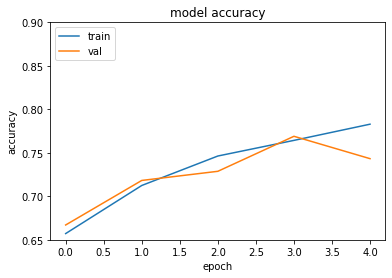

In [8]:
from matplotlib import pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.ylim(0.65,0.9)
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [9]:
# predict test data
y_pred = model.predict(x_test)

In [ ]:
import numpy as np
# convert one hot to labels for test data
pred_label = prepare_training_data.one_hot_to_labels(y_pred)
true_label = prepare_training_data.one_hot_to_labels(y_test)

print('class distribution test data + predicted')
print('-----------------------------------')
for i, label in enumerate(labels):
    print(i,label,':',np.sum(true_label==i), 'pred: ',np.sum(pred_label==i))

In [11]:
# Calc metrics for test data
import sklearn
from sklearn.metrics import precision_score, recall_score
from tabulate import tabulate
label_list = list(labels.keys())

headers = [l for l in label_list ]
headers = [' '] + headers

table=[['precision'] + list(precision_score(true_label, pred_label, average=None)), 
       ['recall']+list(recall_score(true_label, pred_label, average=None)), 
       ['f1']+ list(sklearn.metrics.f1_score(true_label, pred_label, average=None))]

print(tabulate(table, headers=headers, tablefmt='orgtbl'))
f1 = sklearn.metrics.f1_score(true_label, pred_label, average=None)
print('f1 average: ',sum(sklearn.metrics.f1_score(true_label, pred_label, average=None))/len(list(precision_score(true_label, pred_label, average=None))))
print('Precision average: ',sum(precision_score(true_label, pred_label, average=None)/7))
print('recall average: ',sum(recall_score(true_label, pred_label, average=None)/7))
print('acc', sklearn.metrics.accuracy_score(true_label, pred_label))

|           |   Ausbildung |    Beruf |   allgemein |   berufsspez |   Sprache |   Technologie |   Softskill |
|-----------+--------------+----------+-------------+--------------+-----------+---------------+-------------|
| precision |     0.856678 | 0.305085 |    0.507375 |     0.701689 |  0.971698 |      0.723    |    0.900356 |
| recall    |     0.952899 | 0.28125  |    0.482468 |     0.699065 |  0.932127 |      0.932903 |    0.704735 |
| f1        |     0.90223  | 0.292683 |    0.494608 |     0.700375 |  0.951501 |      0.814648 |    0.790625 |
f1 average:  0.7066670774130966
Precision average:  0.7094113488431252
recall average:  0.7122068161666772
acc 0.7432915921288015


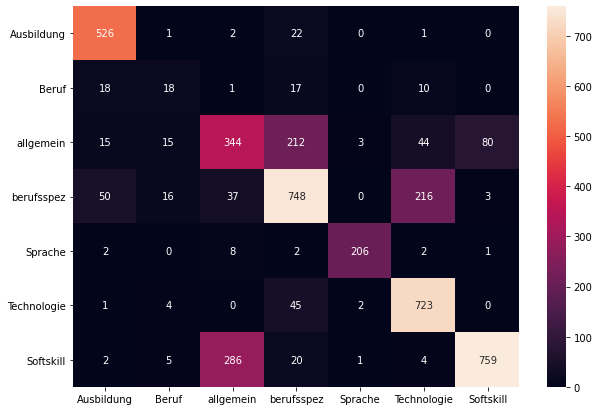

In [12]:
# Create Confusion Matrix

import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labelsi = list(labels)

cm = sklearn.metrics.confusion_matrix(true_label, pred_label)
df_cm = pd.DataFrame(cm, labelsi[:7],columns = labelsi[:7])
plt.figure(figsize = (10,7))
plt.ylabel('Eingabe')
plt.xlabel('Ausgabe')
sn.heatmap(df_cm, annot=True,fmt='g')